In [0]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image
import matplotlib
from sklearn.model_selection import StratifiedKFold
import keras
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Dropout, UpSampling2D, BatchNormalization, Activation, Dense, Lambda, TimeDistributed, Flatten
from keras.layers import LSTM, GRU, RNN, Reshape, CuDNNGRU, CuDNNLSTM
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, MaxPooling3D
from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import Adam
from keras.callbacks import Callback
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import gc
from keras import layers, models, applications
from keras.layers import concatenate
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers, models, applications
from tqdm import tqdm_notebook

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

def random_everything(seed=42):
  os.environ['PYTHONHASHSEED'] = str(42)
  random.seed(42)
  np.random.seed(42)
  tf.set_random_seed(42)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2_m(y_true, y_pred, beta=2):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return (1+beta**2) * (precision*recall) / ((beta**2)*(precision)+recall+K.epsilon())

def f3_m(y_true, y_pred, beta=3):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return (1+beta**2) * (precision*recall) / ((beta**2)*(precision)+recall+K.epsilon())

def f4_m(y_true, y_pred, beta=4):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return (1+beta**2) * (precision*recall) / ((beta**2)*(precision)+recall+K.epsilon())
    
'''
a = []
while(1):
  a.append('1')
'''


Using TensorFlow backend.


"\na = []\nwhile(1):\n  a.append('1')\n"

In [0]:
def ConvBlock(inputs, suffix=0, prefix="cnn"):
    """no final linear dense layer!"""
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_1a")(inputs)
    conv1 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_1a")(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_1b")(conv1)
    conv1 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_1b")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name=f"{prefix}_{suffix}_maxpool_1")(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_2a")(pool1)
    conv2 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_2a")(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_2b")(conv2)
    conv2 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_2b")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=f"index_{suffix}_maxpool_2")(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_3a")(pool2)
    conv3 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_3a")(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_3b")(conv3)
    conv3 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_3b")(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_3c")(conv3)
    conv3 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_3c")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=f"index_{suffix}_maxpool_3")(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_4a")(pool3)
    conv4 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_4a")(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_4b")(conv4)
    conv4 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_4b")(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_4c")(conv4)
    conv4 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_4c")(conv4)    
    pool4 = MaxPooling2D(pool_size=(2, 2), name=f"{prefix}_{suffix}_maxpool_4")(conv4)    

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_5a")(pool4)
    conv5 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_5a")(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_5b")(conv5)
    conv5 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_5b")(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_5c")(conv5)
    conv5 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_5c")(conv5)    
    pool5 = MaxPooling2D(pool_size=(2, 2), name=f"{prefix}_{suffix}_maxpool_5")(conv5)   
    
    flatten= Flatten(name=f"{prefix}_{suffix}_flatten")(pool5)
    dense1 = Dense(512, activation="relu", name=f"{prefix}_{suffix}_relu_1")(flatten)
    drop1  = Dropout(0.4, name=f"{prefix}_{suffix}_drop_1")(dense1)
    dense2 = Dense(128, activation="relu", name=f"{prefix}_{suffix}_relu_2")(drop1)
    drop2  = Dropout(0.3, name=f"{prefix}_{suffix}_drop_2")(dense2)
    dense3 = Dense(32, activation="relu", name=f"{prefix}_{suffix}_relu_3")(drop2)
    drop3  = Dropout(0.2, name=f"{prefix}_{suffix}_drop_3")(dense3)
    dense4 = Dense(8, activation="relu",  name=f"{prefix}_{suffix}_relu_4")(drop3)
    return dense4

def MLP(inputs, suffix=0, prefix='mlp'):
    dense = Dense(8, activation='relu', name=f"{prefix}_{suffix}_relu_1")(inputs)
    dense = Dense(4, activation='relu', name=f"{prefix}_{suffix}_relu_2")(dense)
    return dense
    

In [0]:
n_channels = 14
sector_dim = 200

img_0 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_0")
img_1 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_1")
img_2 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_2")

num_0 = Input((50,), name="gsod_input_0")
num_1 = Input((50,), name="gsod_input_1")
num_2 = Input((10,), name="gsod_input_2")

adj_0 = Input((8,), name="adj_input_0")
adj_1 = Input((8,), name="adj_input_1")
adj_2 = Input((8,), name="adj_input_2")

cnn_0 = ConvBlock(img_0, suffix=0)
cnn_1 = ConvBlock(img_1, suffix=1)
cnn_2 = ConvBlock(img_2, suffix=2)

num_0_m = MLP(num_0, suffix=0, prefix="gsod")
num_1_m = MLP(num_1, suffix=1, prefix="gsod")
num_2_m = MLP(num_2, suffix=2, prefix="gsod")

adj_0_m = MLP(adj_0, suffix=0, prefix="adj")
adj_1_m = MLP(adj_1, suffix=1, prefix="adj")
adj_2_m = MLP(adj_2, suffix=2, prefix="adj")

mixed_0 = concatenate([cnn_0, num_0_m, adj_0_m], name='mixed_0')
mixed_1 = concatenate([cnn_1, num_1_m, adj_1_m], name='mixed_1')
mixed_2 = concatenate([cnn_2, num_2_m, adj_2_m], name='mixed_2')

concat   = concatenate([mixed_0, mixed_1, mixed_2], name="concat_mixed")
reshape  = Reshape((3, -1), name="reshape")(concat)
lstm     = LSTM(256, name='lstm_1', return_sequences=True)(reshape)
lstm     = Dropout(0.4, name='lstm_drop_1')(lstm)
lstm     = LSTM(256, name='lstm_2')(lstm)
lstm     = Dropout(0.4, name='lstm_drop_2')(lstm)
dense    = Dense(10, activation="relu", name="fc_relu")(lstm)
dense    = Dense(1, activation="sigmoid", name="fc_sigmoid")(dense)

model = Model(inputs=[img_0, img_1, img_2, num_0, num_1, num_2, adj_0, adj_1, adj_2], output=dense)
#model.summary()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fc...)`


In [0]:
class Data(object):
    def __init__(self, imgs, labs, zone_idx=np.arange(20), size=108):
        self.imgs = imgs
        self.labs = labs
        self.size = size
        self.zone_idx = zone_idx

    def extract_single_zone(self, imgs, labs, idx=0):
        """extract a single zone based on the index"""
        assert idx >= 0 and idx <= 24
        try:
            assert len(imgs) == self.size
        except Exception:
            imgs = imgs[:self.size,:]     ## if there are more images than labels, cut the images to approporiate size!
        try:
            assert len(labs) == self.size
        except Exception:
            labs = labs[:self.size,:]     

        row_idx = idx//5
        col_idx = idx%5
        return imgs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :], labs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :]
   
    def burn_ratio(self, labs):
        """calculate the burn ratio in an area"""
        ratio = np.zeros((labs.shape[0],))
        for i in range(len(labs)):
          ratio[i] = labs[i,:,:,:].mean()
        return ratio

    def binarize_risk(self, labs, thres=0.05):
        #ratio = labs.sum(axis=-1).sum(axis=-1).sum(axis=-1)/(200*200)
        ratio = self.burn_ratio(labs)
        return (ratio>thres).astype(int)

    def compile_zones(self):
        """concatenate all sector images based on selected index"""
        """Zone 0,0,0,0,0,0,0,0,0 .... Zone 1,1,1,1...."""
        """Normalize to (0, 1) !!!"""
        imgs, labs = self.extract_single_zone(self.imgs, self.labs, idx=self.zone_idx[0])
        for i in range(1, len(self.zone_idx)):
            I, L = self.extract_single_zone(self.imgs, self.labs, idx=self.zone_idx[i])
            imgs = np.concatenate([imgs, I], 0)
            labs = np.concatenate([labs, L], 0)
        imgs = imgs/imgs.max()
        imgs = imgs.astype('float32')
        return imgs, labs
        
    def prepare_step_data(self):
        zoned_imgs, zoned_labs = self.compile_zones()
        idx = np.array([i for i in range(len(zoned_imgs)) if i % self.size not in [self.size-2, self.size-1, self.size]])
        imgs_0 = zoned_imgs[idx, :,:,:]
        imgs_1 = zoned_imgs[idx+1, :,:,:]
        imgs_2, labs = zoned_imgs[idx+2, :,:,:], self.binarize_risk(zoned_labs[idx+2])
        return imgs_0, imgs_1, imgs_2, labs


class Adjacency(object):
    """Only to extract burn ratio from label, no images, no binarized labels, burn ratio is the feature to extract"""
    def __init__(self, labs, zone_idx=np.arange(20), size=108):
        self.labs = labs
        self.size = size
        self.zone_idx = zone_idx
    
    def extract_single_zone(self, labs, idx=0):
        """extract a single zone based on the index"""
        assert idx >= 0 and idx <= 24
        try:
            assert len(labs) == self.size
        except Exception:
            labs = labs[:self.size,:]     
        row_idx = idx//5
        col_idx = idx%5
        return labs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :]

    def burn_ratio(self,labs):
        """calculate the burn ratio in an area"""
        ratio = np.zeros((labs.shape[0],))
        for i in range(len(labs)):
          ratio[i] = labs[i,:,:,:].mean()
        return ratio
    
    def binarize_risk(self,labs, thres=0.05):
        ratio = labs.sum(axis=-1).sum(axis=-1).sum(axis=-1)/(200*200)
        return (ratio>thres).astype(int)

    def compile_zones(self):
        """concatenate all sector images based on selected index"""
        """Zone 0,0,0,0,0,0,0,0,0 .... Zone 1,1,1,1...."""
        """Normalize to (0, 1) !!!"""
        labs = self.extract_single_zone(self.labs, idx=self.zone_idx[0])
        for i in range(1, len(self.zone_idx)):
            L = self.extract_single_zone(self.labs, idx=self.zone_idx[i])
            labs = np.concatenate([labs, L], 0)
        return labs

    def prepare_step_data(self):
        zoned_labs = self.compile_zones()
        idx = np.array([i for i in range(len(zoned_labs)) if i % self.size not in [self.size-2, self.size-1, self.size]])
        adj_0 = self.burn_ratio(zoned_labs[idx])
        adj_1 = self.burn_ratio(zoned_labs[idx+1])
        adj_2 = self.burn_ratio(zoned_labs[idx+2])
        return adj_0, adj_1, adj_2

def extract_adjacency_feature(indices, mode='trn_val'):
    """
    Function to extract adjacency features
    indices must be in list format,
    mode can be either trn_val or test
    """
    names = ['south','southwest','west','northwest','north','northeast','east','southeast']
    
    def subset_adjacency(which=0):
        """Extract adjacency feature based on 1 direction"""
        name = names[which]
        row = 200
        col = 200
        if 'south' in name:
            row = 400
        elif 'north' in name:
            row = 0
        if 'west' in name:
            col = 0
        elif 'east' in name:
            col = 400
        return adjacency_full[:,row:row+1000,col:col+1000,:]
    
    if mode == 'trn_val':
        trn_adj_0_list = []
        trn_adj_1_list = []
        trn_adj_2_list = []
    
        val_adj_0_list = []
        val_adj_1_list = []
        val_adj_2_list = []

        trn_idx = indices[0]
        val_idx = indices[1]
        for i in tqdm_notebook(range(8)):
            adjacency_full = np.load('/content/gdrive/My Drive/adjacency.npz')['dnbr']
            adjacency = subset_adjacency(which=i)
            """binarize to burn or unburnt pixels"""
            adjacency = (adjacency>0.66).astype(int)
            """Adjacency feature is always taken on timestep prior!!! This is to avoid data leakage!!!"""
            adjacency = np.concatenate([np.zeros((1,1000,1000,1), dtype='int'), adjacency[:-1]],0)
            del adjacency_full
            gc.collect()
            trn_data = Adjacency(adjacency, zone_idx=trn_idx)
            val_data = Adjacency(adjacency, zone_idx=val_idx)
            del adjacency
            gc.collect()
            trn_adj_0, trn_adj_1, trn_adj_2 = trn_data.prepare_step_data()
            val_adj_0, val_adj_1, val_adj_2 = val_data.prepare_step_data()
            del trn_data, val_data
            gc.collect()
            trn_adj_0_list.append(trn_adj_0)
            trn_adj_1_list.append(trn_adj_1)
            trn_adj_2_list.append(trn_adj_2)
            val_adj_0_list.append(val_adj_0)
            val_adj_1_list.append(val_adj_1)
            val_adj_2_list.append(val_adj_2)

        trn_adj_0_list = np.column_stack(trn_adj_0_list)
        trn_adj_1_list = np.column_stack(trn_adj_1_list)
        trn_adj_2_list = np.column_stack(trn_adj_2_list)
        val_adj_0_list = np.column_stack(val_adj_0_list)
        val_adj_1_list = np.column_stack(val_adj_1_list)
        val_adj_2_list = np.column_stack(val_adj_2_list)

        return trn_adj_0_list, trn_adj_1_list, trn_adj_2_list, val_adj_0_list, val_adj_1_list, val_adj_2_list

    elif mode == 'test':
        test_adj_0_list = []
        test_adj_1_list = []
        test_adj_2_list = []

        test_idx = indices[0]
        for i in tqdm_notebook(range(8)):
            adjacency_full = np.load('/content/gdrive/My Drive/adjacency.npz')['dnbr']
            adjacency = subset_adjacency(which=i)
            adjacency = (adjacency>0.66).astype(int)
            adjacency = np.concatenate([np.zeros((1,1000,1000,1), dtype='int'), adjacency[:-1]],0)
            del adjacency_full
            gc.collect()
            test_data = Adjacency(adjacency, zone_idx=test_idx)
            del adjacency
            gc.collect()
            test_adj_0, test_adj_1, test_adj_2 = test_data.prepare_step_data()
            del test_data
            gc.collect()
            test_adj_0_list.append(test_adj_0)
            test_adj_1_list.append(test_adj_1)
            test_adj_2_list.append(test_adj_2)

        test_adj_0_list = np.column_stack(test_adj_0_list)
        test_adj_1_list = np.column_stack(test_adj_1_list)
        test_adj_2_list = np.column_stack(test_adj_2_list)

        return test_adj_0_list, test_adj_1_list, test_adj_2_list


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


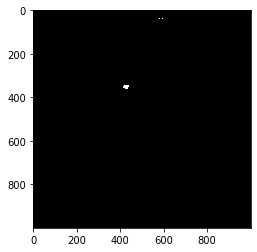

In [0]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

water_mask = np.load('/content/gdrive/My Drive/water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
plt.imshow(water_mask[:,:,0], cmap='Greys_r')

In [0]:
I = 4
trn_idx = [i for i in range(25) if i not in range(5*I, 5*I+5)]
val_idx = [i for i in range(25) if i in range(5*I, 5*I+5)]

imgs = np.load('/content/gdrive/My Drive/cloud_control_data.npz')['imgs']
dnbr = np.load('/content/gdrive/My Drive/adjacency.npz')['dnbr']
dnbr = dnbr[:,200:1200,200:1200,:]

labs = (dnbr>0.66).astype(int)
del dnbr
gc.collect()
## apply water mask
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0

trn_data = Data(imgs, labs, zone_idx=trn_idx)
val_data = Data(imgs, labs, zone_idx=val_idx)

del imgs, labs
gc.collect()

x_trn_0, x_trn_1, x_trn_2, y_trn = trn_data.prepare_step_data()
x_val_0, x_val_1, x_val_2, y_val = val_data.prepare_step_data()

del trn_data, val_data, water_mask
gc.collect()

try:
    adj_trn_0 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_trn_0']
    adj_trn_1 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_trn_1']
    adj_trn_2 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_trn_2']

    adj_val_0 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_val_0']
    adj_val_1 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_val_1']
    adj_val_2 = np.load(f'/content/gdrive/My Drive/adjacency_features_{I}.npz')['adj_val_2']

except Exception:
    adj_trn_0, adj_trn_1, adj_trn_2, adj_val_0, adj_val_1, adj_val_2 = extract_adjacency_feature([trn_idx, val_idx])
    np.savez_compressed(f'/content/gdrive/My Drive/adjacency_features_{I}', adj_trn_0=adj_trn_0, adj_trn_1=adj_trn_1, adj_trn_2=adj_trn_2, adj_val_0=adj_val_0, adj_val_1=adj_val_1, adj_val_2=adj_val_2)


In [0]:
gsod = pd.read_csv('/content/gdrive/My Drive/flinders_chase_clean_5day.csv').values
gsod = np.array(gsod, dtype='float')
## normalize
gsod = gsod/gsod.max(axis=0)

num_trn_0, num_trn_1, num_trn_2 = gsod[:-2,:], gsod[1:-1,:], gsod[2:,:10]
num_val_0, num_val_1, num_val_2 = gsod[:-2,:], gsod[1:-1,:], gsod[2:,:10]
for i in range(len(trn_idx)-1):
  num_trn_0 = np.concatenate([num_trn_0, gsod[:-2,:]])
  num_trn_1 = np.concatenate([num_trn_1, gsod[1:-1,:]])
  ### the last series should only have day_0 data!
  num_trn_2 = np.concatenate([num_trn_2, gsod[2:,:10]])
for i in range(len(val_idx)-1):
  num_val_0 = np.concatenate([num_val_0, gsod[:-2,:]])
  num_val_1 = np.concatenate([num_val_1, gsod[1:-1,:]])
  ### the last series should only have day_0 data!
  num_val_2 = np.concatenate([num_val_2, gsod[2:,:10]])

In [0]:
def custom_loss(y_true, y_pred, w=20):
    crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
    weight  = (y_true*(w-1)) + 1
    return crossentropy_loss*(weight)*(1/w)

def f2_loss(y_true, y_pred, beta=2):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f_score = (1+beta**2) * p * r / ( (beta**2) * p + r + K.epsilon())
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return 1 - K.mean(f_score)

def f4_loss(y_true, y_pred, beta=4):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f_score = (1+beta**2) * p * r / ( (beta**2) * p + r + K.epsilon())
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return 1 - K.mean(f_score)
def custom_loss(y_true, y_pred, w=20):
    crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
    weight  = (y_true*(w-1)) + 1
    return crossentropy_loss*(weight)*(1/w)

def f2_loss(y_true, y_pred, beta=2):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f_score = (1+beta**2) * p * r / ( (beta**2) * p + r + K.epsilon())
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return 1 - K.mean(f_score)

def f4_loss(y_true, y_pred, beta=4):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f_score = (1+beta**2) * p * r / ( (beta**2) * p + r + K.epsilon())
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return 1 - K.mean(f_score)


In [0]:
random_everything(seed=42)
#model = Model(inputs=[img_0, img_1, img_2, num_0, num_1, num_2, adj_0, adj_1, adj_2], output=dense)

model.compile(optimizer = Adam(lr=2e-5, decay=1e-6), 
              #loss=custom_loss,
              loss=f4_loss,
              metrics=['acc', recall_m, precision_m, f1_m, f2_m, f3_m, f4_m])

ckpt = ModelCheckpoint(f"/content/gdrive/My Drive/CNN_LSTM_{I}_final.hdf5", monitor = "val_f4_m", save_best_only = True, mode = "max", save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit([x_trn_0, x_trn_1, x_trn_2, num_trn_0, num_trn_1, num_trn_2, adj_trn_0, adj_trn_1, adj_trn_2], y_trn,
                        validation_data=([x_val_0, x_val_1, x_val_2, num_val_0, num_val_1, num_val_2, adj_val_0, adj_val_1, adj_val_2], y_val),
                        batch_size=24, epochs=100,
                        callbacks=[es, ckpt, 
                                   keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8 )
                                   ]
                        )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2120 samples, validate on 530 samples
Epoch 1/100
2120/2120 [==============================] - 102s 48ms/step - loss: 0.7386 - acc: 0.0434 - recall_m: 0.6679 - precision_m: 0.0425 - f1_m: 0.0790 - f2_m: 0.1641 - f3_m: 0.2587 - f4_m: 0.3420 - val_loss: 0.6940 - val_acc: 0.0491 - val_recall_m: 0.6377 - val_precision_m: 0.0491 - val_f1_m: 0.0898 - val_f2_m: 0.1817 - val_f3_m: 0.2790 - val_f4_m: 0.3601
Epoch 2/100
2120/2120 [==============================] - 77s 36ms/step - loss: 0.7078 - acc: 0.0425 - recall_m: 0.6226 - precision_m: 0.0425 - f1_m: 0.0784 - f2_m: 0.1606 - f3_m: 0.2500 - f4_m: 0.3272 - val_loss: 0.6636 - val_acc: 0.0491 - val_recall_m: 0.6377 - val_precision_m: 0.0491 - val_f1_m: 0.0898 - val_f2_m: 0.1817 - val_f3_m: 0.2790 - val_f4_m: 0.3601
Epoch 3/100
2120/2120 [==============================] - 77s 36ms/step - loss: 0.6809 - acc: 0.0425 - recall_m: 0.6377 - precisio

In [0]:
model.load_weights(f"/content/gdrive/My Drive/CNN_LSTM_{I}_final.hdf5")
preds = model.predict([x_val_0, x_val_1, x_val_2, num_val_0, num_val_1, num_val_2, adj_val_0, adj_val_1, adj_val_2])
#np.save(f'/content/gdrive/My Drive/preds_{I}', preds)


In [0]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, cohen_kappa_score

print(accuracy_score(y_val, preds.round().flatten()))
print(f1_score(y_val, preds.round().flatten()))
print(fbeta_score(y_val, preds.round().flatten(),2))
print(fbeta_score(y_val, preds.round().flatten(),3))
print(fbeta_score(y_val, preds.round().flatten(),4))
print(cohen_kappa_score(y_val, preds.round().flatten()))
print(recall_score(y_val, preds.round().flatten()))
print(precision_score(y_val, preds.round().flatten()))


0.9056603773584906
0.47916666666666663
0.660919540229885
0.756578947368421
0.8045267489711934
0.4390347163420829
0.8846153846153846
0.32857142857142857


In [0]:
test_imgs_0 = np.load('/content/gdrive/My Drive/test_data.npz')['test_imgs_0']
test_imgs_1 = np.load('/content/gdrive/My Drive/test_data.npz')['test_imgs_1']
test_imgs_2 = np.load('/content/gdrive/My Drive/test_data.npz')['test_imgs_2']
test_adj_0 = np.load('/content/gdrive/My Drive/test_data.npz')['test_adj_0']
test_adj_1 = np.load('/content/gdrive/My Drive/test_data.npz')['test_adj_1']
test_adj_2 = np.load('/content/gdrive/My Drive/test_data.npz')['test_adj_2']
test_labs = np.load('/content/gdrive/My Drive/test_data.npz')['test_lab']


In [0]:
test_gsod = pd.read_csv('/content/gdrive/My Drive/test_gsod_final.csv').values
test_gsod_0, test_gsod_1, test_gsod_2 = test_gsod[:-2,:], test_gsod[1:-1,:], test_gsod[2:,:10]
for i in range(1,25):
    test_gsod_0 = np.concatenate([test_gsod_0, test_gsod[:-2,:]])
    test_gsod_1 = np.concatenate([test_gsod_1, test_gsod[1:-1,:]])
    test_gsod_2 = np.concatenate([test_gsod_2, test_gsod[2:,:10]])

In [0]:
I = 4
model.load_weights(f"/content/gdrive/My Drive/CNN_LSTM_{I}_final.hdf5")
test_preds = model.predict([test_imgs_0, test_imgs_1, test_imgs_2, test_gsod_0, test_gsod_1, test_gsod_2, test_adj_0, test_adj_1, test_adj_2])
np.save(f'/content/gdrive/My Drive/test_preds_{I}', test_preds.flatten())


In [0]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, cohen_kappa_score

print(accuracy_score(test_labs, test_preds.round().flatten()))
print(f1_score(test_labs, test_preds.round().flatten()))
print(fbeta_score(test_labs, test_preds.round().flatten(),2))
print(fbeta_score(test_labs, test_preds.round().flatten(),3))
print(fbeta_score(test_labs, test_preds.round().flatten(),4))
print(cohen_kappa_score(test_labs, test_preds.round().flatten()))
print(recall_score(test_labs, test_preds.round().flatten()))
print(precision_score(test_labs, test_preds.round().flatten()))


0.68
0.5555555555555556
0.4807692307692307
0.460122699386503
0.4521276595744681
0.33085501858736055
0.4411764705882353
0.75
